In [ ]:
# https://towardsdatascience.com/hands-on-generative-adversarial-networks-gan-for-signal-processing-with-python-ff5b8d78bd28

In [1]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
# https://stackoverflow.com/questions/68036975/valueerror-shape-must-be-at-least-rank-3-but-is-rank-2-for-node-biasadd
# config for rank error in lstm
tf.keras.backend.set_image_data_format("channels_last")

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
# tf.config.run_functions_eagerly(True)

In [207]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
sequences = [
    ['apple', 'banana'],
    ['apple', 'orange', ],
    ['orange', 'pear'],
    ['banana', 'pear'],
    ['apple', 'pear'],
]
vocab = list(set(value for sequence in sequences for value in sequence))

tokenizer.fit_on_texts(vocab)
word_index = tokenizer.word_index
vocab_count = len(vocab)

seq_enc = tokenizer.texts_to_sequences(sequences)
seq_enc_tensor = tf.one_hot(seq_enc, vocab_count)

In [4]:
seq_enc_tensor.shape

TensorShape([5, 2, 4])

In [5]:
vocab

['pear', 'orange', 'apple', 'banana']

In [245]:
seq_enc_tensor.shape
# shape - (input_len, sequence_length, vocab_size)
input_len = seq_enc_tensor.shape[0]
sequence_length = seq_enc_tensor.shape[1]

In [262]:
def define_generator():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sequence_length, vocab_count)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_count, activation='softmax')),
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

def define_discriminator():
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(sequence_length, vocab_count)),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dense(2, activation='softmax'),
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

    return model

def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    return model

def generate_latent_space():
    n = tf.random.uniform(shape=[input_len, sequence_length, vocab_count], minval=1, maxval=vocab_count, dtype=tf.int32)
    return n

def generate_fake_samples(generator):
    # generate points in latent space & pass through generator
    x = generator.predict(generate_latent_space(), verbose=0)
    # create class labels
    y = zeros((input_len,1))
    return x, y

def generate_real_samples():
    x = seq_enc_tensor
    # create class labels
    y = ones((input_len,1))
    return x, y

def train(g_model, d_model, gan_model, epochs=5, n_eval=20):
    d_acc_history = []
    d_loss_history = []
    g_acc_history = []
    g_loss_history = []

    d_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    g_metric = tf.keras.metrics.CategoricalAccuracy()

    # manually enumerate epochs
    for i in range(epochs):
        # prepare real samples
        x_real, y_real = generate_fake_samples(g_model)
        # prepare fake examples using the generator
        x_fake, y_fake = generate_fake_samples(g_model)

        # update discriminator
        d_real_loss = d_model.train_on_batch(x_real, y_real)
        d_fake_loss = d_model.train_on_batch(x_fake, y_fake)
        d_loss = 0.5 * (d_real_loss + d_fake_loss)

        d_real_pred = d_model.predict_on_batch(x_real)
        d_fake_pred = d_model.predict_on_batch(x_fake)

        d_metric.update_state(tf.concat([y_real, y_fake], axis=0), tf.concat([d_real_pred, d_fake_pred], axis=0))
        d_acc = d_metric.result().numpy()

        # prepare points in latent space as input for the generator
        x_gan = generate_latent_space()
        y_gan = ones((input_len, 1))
        g_loss = gan_model.train_on_batch(x_gan, y_gan)

        # update the generator via the discriminator's error
        gan_pred = gan_model.predict_on_batch(x_gan)
        g_metric.update_state(tf.one_hot(tf.cast(y_gan, tf.int32), depth=2), gan_pred)
        g_acc = g_metric.result().numpy()

        d_acc_history.append(d_acc)
        d_loss_history.append(d_loss)
        g_acc_history.append(g_acc)
        g_loss_history.append(g_loss)

        if i % n_eval == 0:
            print(f"Epoch {i}: Discriminator Loss: {d_loss}, Discriminator Accuracy: {d_acc}, Generator Loss: {g_loss}, Generator Accuracy: {g_acc}")

    return d_acc_history, d_loss_history, g_acc_history, g_loss_history

In [237]:
generator = define_generator()
discriminator = define_discriminator()
gan = define_gan(generator, discriminator)

In [238]:
# Generate a new sequence
new_seq = generator.predict(seq_enc_tensor)

1/1 [==============================] - 0s 391ms/step


In [180]:
generator.train_on_batch(seq_enc_tensor, seq_enc_tensor)

1.0354931354522705

In [182]:
# Generate a new sequence using the generator model
new_seq_enc_tensor = generator.predict(seq_enc_tensor)
new_seq_enc = tf.argmax(new_seq_enc_tensor, axis=-1)
new_seq_texts = tokenizer.sequences_to_texts(new_seq_enc.numpy())

1/1 [==============================] - 0s 23ms/step


In [183]:
real_labels = np.ones((input_len,1))

In [184]:
seq_enc_tensor

<tf.Tensor: shape=(4, 2, 4), dtype=float32, numpy=
array([[[0., 0., 0., 1.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 1.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 1., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 1., 0., 0.]]], dtype=float32)>

In [185]:
new_seq_enc_tensor

array([[[0.22890307, 0.25438273, 0.25260112, 0.26411307],
        [0.22256249, 0.2558569 , 0.2667343 , 0.25484627]],

       [[0.22890307, 0.25438273, 0.25260112, 0.26411307],
        [0.21812   , 0.25585574, 0.2752338 , 0.25079042]],

       [[0.23429134, 0.25710458, 0.26196784, 0.24663626],
        [0.21594815, 0.29405177, 0.2545723 , 0.23542777]],

       [[0.23861347, 0.25671118, 0.2540479 , 0.25062743],
        [0.22390462, 0.28179562, 0.25251472, 0.24178505]]], dtype=float32)

In [186]:
new_seq

array([[[0.24541563, 0.2545657 , 0.24852131, 0.25149736],
        [0.24674027, 0.25282878, 0.24967848, 0.25075242]],

       [[0.24541563, 0.2545657 , 0.24852131, 0.25149736],
        [0.24853157, 0.25272974, 0.24583218, 0.2529065 ]],

       [[0.25202346, 0.25003633, 0.24613915, 0.25180104],
        [0.24696983, 0.25730047, 0.24691926, 0.24881041]],

       [[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.246324  , 0.25644928, 0.24981754, 0.24740922]]], dtype=float32)

In [187]:
[i.argmax(-1) for i in new_seq_enc_tensor]

[array([3, 2]), array([3, 2]), array([2, 1]), array([1, 1])]

In [188]:
print(new_seq_texts)

['apple orange', 'apple orange', 'orange pear', 'pear pear']


In [189]:
vocab

['pear', 'orange', 'apple', 'banana']

In [191]:
discriminator.train_on_batch(new_seq_enc_tensor, real_labels)

0.6982908248901367

In [192]:
discriminator.predict(new_seq_enc_tensor)

1/1 [==============================] - 0s 394ms/step


array([[0.49657774, 0.5034222 ],
       [0.49648222, 0.50351775],
       [0.49634266, 0.5036574 ],
       [0.49656126, 0.5034388 ]], dtype=float32)

In [212]:
gan.train_on_batch(new_seq_enc_tensor, real_labels)

0.6911920309066772

In [267]:
epochs = 101
d_acc_history, d_loss_history, g_acc_history, g_loss_history = train(generator, discriminator, gan, epochs=epochs)

Epoch 0: Discriminator Loss: 0.000488293168018572, Discriminator Accuracy: 1.0, Generator Loss: 7.636820316314697, Generator Accuracy: 0.0
Epoch 20: Discriminator Loss: 0.0004007251700386405, Discriminator Accuracy: 1.0, Generator Loss: 7.825855255126953, Generator Accuracy: 0.0
Epoch 40: Discriminator Loss: 0.000338079989887774, Discriminator Accuracy: 1.0, Generator Loss: 7.998559474945068, Generator Accuracy: 0.0
Epoch 60: Discriminator Loss: 0.00028871899121440947, Discriminator Accuracy: 1.0, Generator Loss: 8.162408828735352, Generator Accuracy: 0.0
Epoch 80: Discriminator Loss: 0.0002507968310965225, Discriminator Accuracy: 1.0, Generator Loss: 8.299178123474121, Generator Accuracy: 0.0
Epoch 100: Discriminator Loss: 0.00021969051158521324, Discriminator Accuracy: 1.0, Generator Loss: 8.428546905517578, Generator Accuracy: 0.0


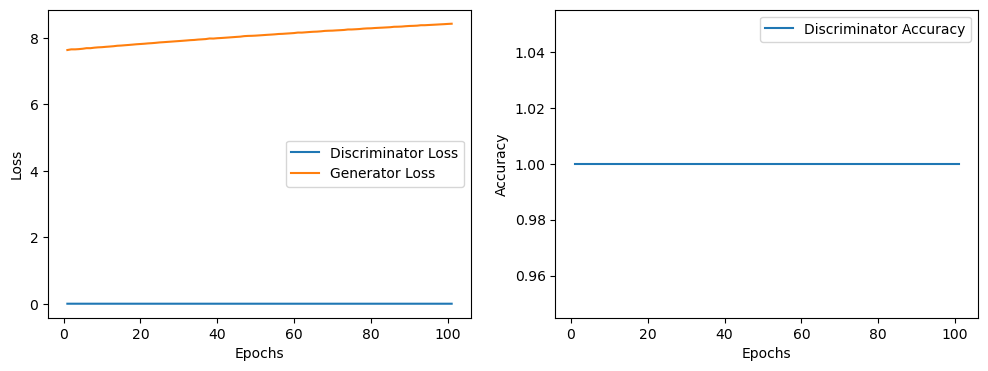

In [268]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, epochs + 1), d_loss_history, label='Discriminator Loss')
ax1.plot(range(1, epochs + 1), g_loss_history, label='Generator Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, epochs + 1), d_acc_history, label='Discriminator Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()